# Week 5: Intro to Deep Learning with fast.ai

## 1. Introduction
- Goal: Train a CNN image classifier on the Oxford-IIIT Pet dataset.
- Tools: Google Colab (T4 GPU), fast.ai library
- Key tasks: setup → data → model → tuning → predictions → reflection

## 2. Environment Setup
Run these in **Google Colab**:
- Enable GPU: Runtime → Change runtime type → GPU
- Install fastbook & verify GPU availability.

In [ ]:
!pip install -Uqq fastbook
import fastbook

fastbook.setup_book()
!nvidia-smi

Mon Oct 13 19:14:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3. Dataset Preparation
- Download the Oxford-IIIT Pet dataset.
- Create DataLoaders with `DataBlock`.

In [ ]:
from fastbook import *
from fastai.vision.all import *

# Download and unpack the data
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
files = get_image_files(path / "images")

# Create DataLoaders
dls = ImageDataLoaders.from_name_re(
    path / "images",
    files,
    pat=r"^(.+)_\d+.jpg$",
    item_tfms=Resize(224),
    valid_pct=0.2,
    seed=42,
)

print(f"Total number of image files: {len(files)}")
print(f"Training batches: {len(dls.train)}, Validation batches: {len(dls.valid)}")
print(
    f"Approx. training items: {len(dls.train)*dls.bs}, Approx. validation items: {len(dls.valid)*dls.bs}"
)

Total number of image files: 7390
Training batches: 92, Validation batches: 24
Approx. training items: 5888, Approx. validation items: 1536


Input range: 0.0 to 1.0


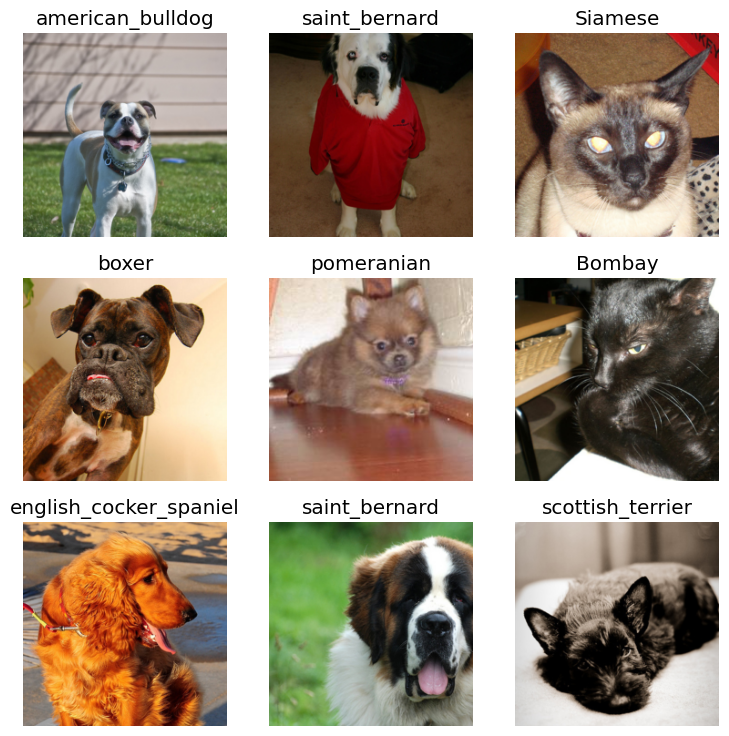

In [ ]:
# Verify your data looks normal
dls.show_batch(max_n=9)

In [ ]:
print("Number of breeds:", len(dls.vocab))

# Print datablock label in a nice list
for i, breed in enumerate(dls.vocab):
    print(f"{i+1:2d}. {breed}")

Number of breeds: 37
 1. Abyssinian
 2. Bengal
 3. Birman
 4. Bombay
 5. British_Shorthair
 6. Egyptian_Mau
 7. Maine_Coon
 8. Persian
 9. Ragdoll
10. Russian_Blue
11. Siamese
12. Sphynx
13. american_bulldog
14. american_pit_bull_terrier
15. basset_hound
16. beagle
17. boxer
18. chihuahua
19. english_cocker_spaniel
20. english_setter
21. german_shorthaired
22. great_pyrenees
23. havanese
24. japanese_chin
25. keeshond
26. leonberger
27. miniature_pinscher
28. newfoundland
29. pomeranian
30. pug
31. saint_bernard
32. samoyed
33. scottish_terrier
34. shiba_inu
35. staffordshire_bull_terrier
36. wheaten_terrier
37. yorkshire_terrier


## 4. Model Training
- Create a CNN learner using a pretrained ResNet-34 backbone.
- Train with `fine_tune()`.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.468806,0.331092,0.108254,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.445002,0.238312,0.078484,00:42


## 5. Learning Rate & Epoch Tuning
- Find the optimal learning rate.
- Train with more epochs and record metrics.

SuggestedLRs(valley=2.1877616745769046e-05)


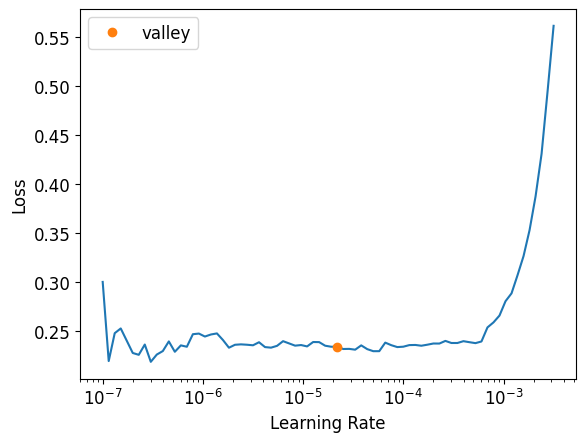

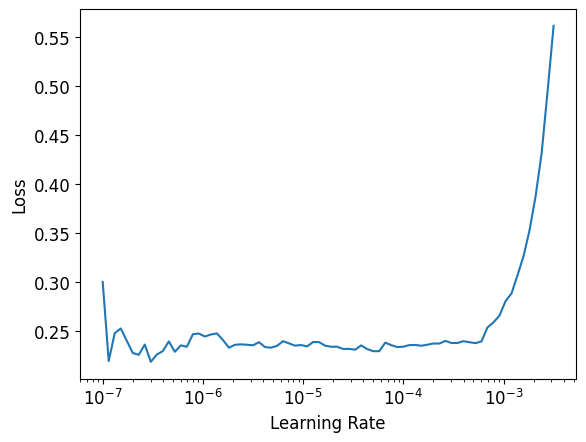

In [ ]:
# Run lr_find with a lower start and higher end
lr_result = learn.lr_find(start_lr=1e-7, end_lr=1e-1)

# Plot the result
learn.recorder.plot_lr_find()

print(lr_result)

Ran different learning rate results, none got the standard U-shape curve graph but got the following:
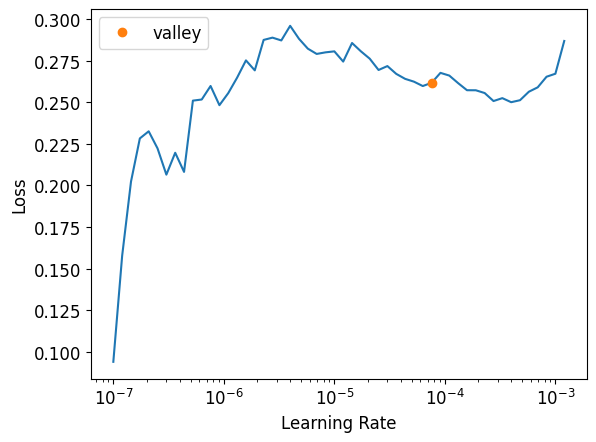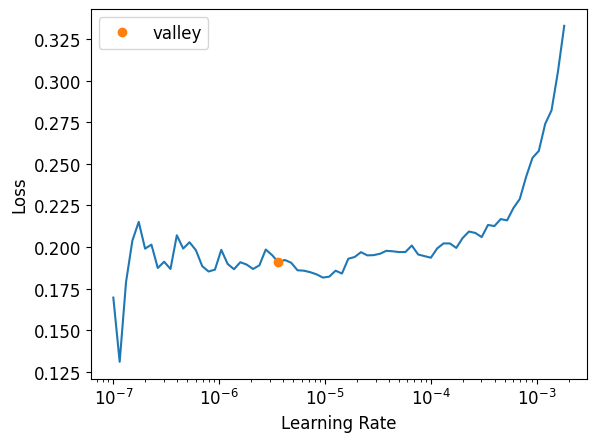
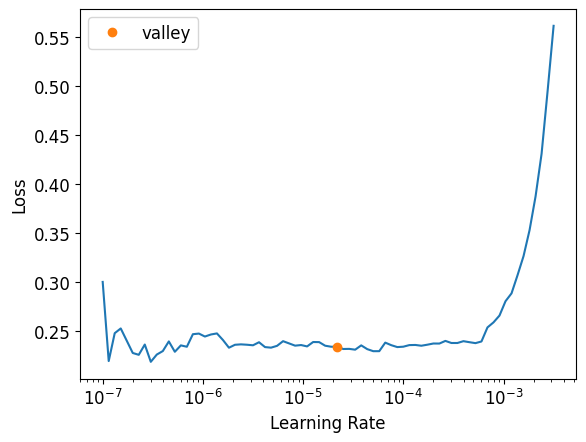

In [ ]:
# Choose lr based on the plot, SuggestedLRs(valley=2.1877616745769046e-05)
suggested_lr = 2.1877616745769046e-05 / 2
learn.fine_tune(3, base_lr=suggested_lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.247097,0.232561,0.076455,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.264687,0.232534,0.075101,00:46
1,0.234270,0.232439,0.077808,00:48
2,0.227338,0.232575,0.077808,00:50


- Achieved an error rate of around 7.78%

## 6. Predictions on New Images
- Upload a new image and use `learn.predict()` to classify it.

In [ ]:
img1 = PILImage.create("/content/chihuahua-1.webp")
img2 = PILImage.create(
    "/content/alimentation-chat-ragdoll-rations-croquettes-patee_a633890c-f4c5-4a9c-8cc2-d55da81a49e1.webp"
)
img3 = PILImage.create("/content/japanese-chin_1024x1024.webp")

print("Prediction on the first image: ", learn.predict(img1)[0])
print("Prediction on the second image: ", learn.predict(img2)[0])
print("Prediction on the third image: ", learn.predict(img3)[0])

Prediction on the first image:  chihuahua


Prediction on the second image:  Ragdoll


Prediction on the third image:  japanese_chin


##Results of model 1:
- Prediction on the first image:  chihuahua
- Prediction on the second image:  Ragdoll
- Prediction on the third image:  japanese_chin

Previously tried testing Dachshund puppy and Shih Tzu image that's not in the training data and received the result of English Cocker Spaniel and Japanese Chin which are pretty similar breeds that existed in the training data. Which pushed me to look for and train a model with lower error rate

## 7. Strategies to Improve Accuracy
####1 Add More Data Augmentation

In [ ]:
# Enhanced DataBlock with stronger augmentations
dls2 = ImageDataLoaders.from_name_re(
    path / "images",
    files,
    pat=r"^(.+)_\d+.jpg$",
    item_tfms=Resize(456),  # Larger initial size
    batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats),
    ],
    valid_pct=0.2,
    bs=32,  # Smaller batch size for better generalization
)

print(f"Training batches: {len(dls2.train)}, Validation batches: {len(dls2.valid)}")

Training batches: 184, Validation batches: 47


In [ ]:
learn2 = vision_learner(dls2, resnet34, metrics=error_rate)
learn2.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.059331,0.414352,0.129905,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.518172,0.288637,0.093369,01:07


SuggestedLRs(valley=1.9054607037105598e-05)


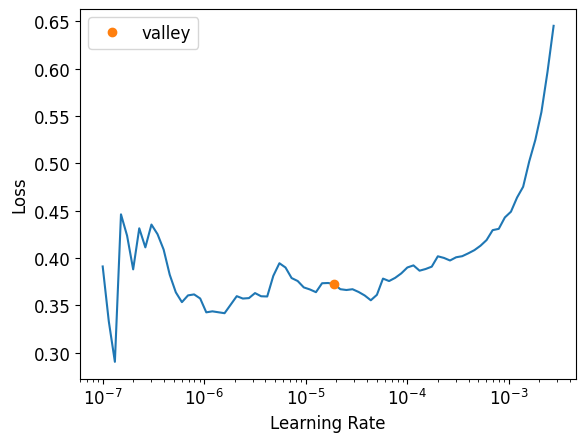

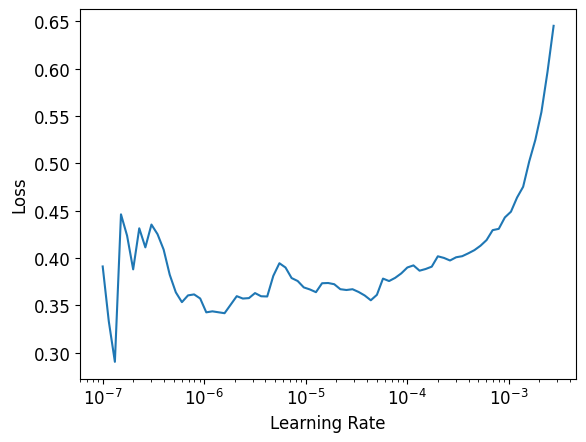

In [ ]:
# Run lr_find with a lower start and higher end
lr_result2 = learn2.lr_find(start_lr=1e-7, end_lr=1e-1)

# Plot the result
learn2.recorder.plot_lr_find()

print(lr_result2)

The learning path graph for improvement strategy 1 is:
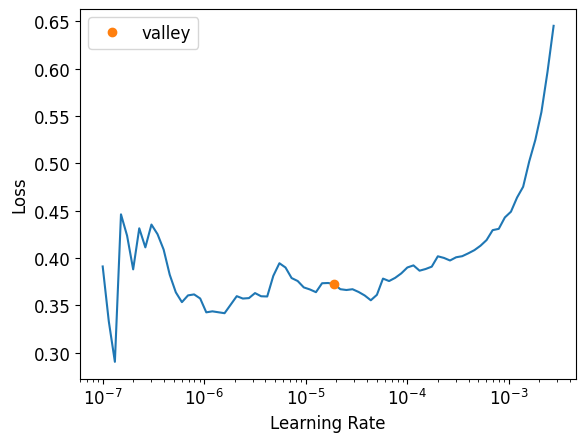

In [ ]:
# Choose lr based on the plot, SuggestedLRs(valley=1.9054607037105598e-05)
learn2.fine_tune(3, base_lr=1.9054607037105598e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.387612,0.279992,0.085250,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.350724,0.265052,0.086604,01:10
1,0.333872,0.261368,0.081191,01:06
2,0.326225,0.261135,0.086604,01:06


- The new error rate for model 2 is 8.66%

In [ ]:
print(
    "Prediction on the first image from the stronger augmentations datablock: ",
    learn2.predict(img1)[0],
)
print(
    "Prediction on the second image from the stronger augmentations datablock: ",
    learn2.predict(img2)[0],
)
print(
    "Prediction on the third image from the stronger augmentations datablock: ",
    learn2.predict(img3)[0],
)

Prediction on the first image from the stronger augmentations datablock:  chihuahua


Prediction on the second image from the stronger augmentations datablock:  Ragdoll


Prediction on the third image from the stronger augmentations datablock:  japanese_chin


##Results of model 2:
- Prediction on the first image:  chihuahua
- Prediction on the second image:  Ragdoll
- Prediction on the third image:  japanese_chin

####2 Use Progressive Resizing

In [ ]:
# Train on smaller size first
learn3 = vision_learner(dls, resnet34, metrics=error_rate)
learn3.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,4.718639,2.728953,0.746279,00:40
1,2.740501,1.013010,0.246279,00:40
2,1.691106,0.650267,0.165088,00:41
3,1.281351,0.571010,0.152909,00:41
4,1.136734,0.557946,0.146143,00:41


SuggestedLRs(valley=0.0009120108443312347)


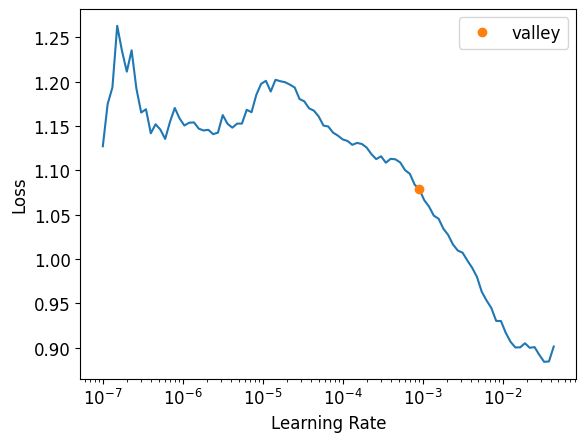

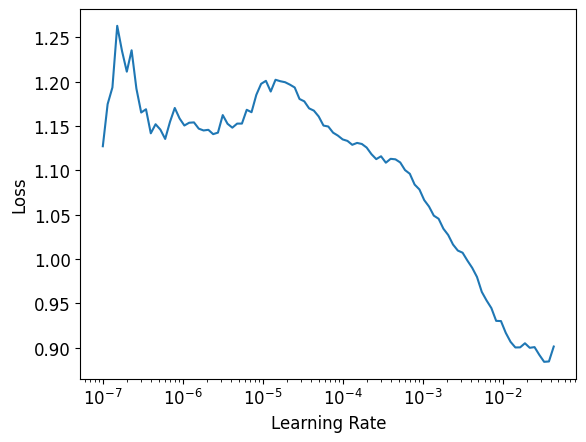

In [ ]:
# Run lr_find with a lower start and higher end
lr_result3 = learn3.lr_find(start_lr=1e-7, end_lr=1e-1)

# Plot the result
learn3.recorder.plot_lr_find()

print(lr_result3)

The new learning rate curve graph for model 3 is this: 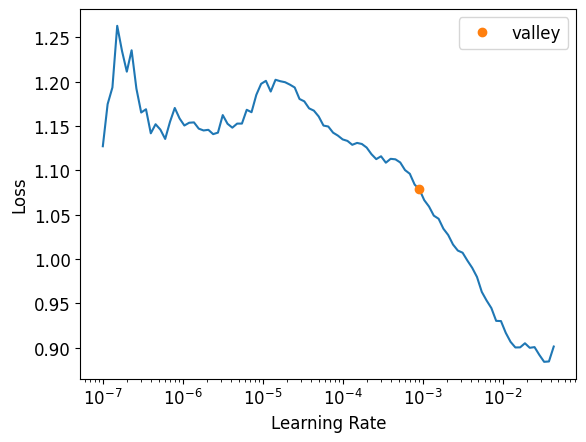

In [ ]:
# Then create new DataLoaders with larger size and augmentations
dls_larger = ImageDataLoaders.from_name_re(
    path / "images",
    files,  # Use the files list obtained earlier
    pat=r"^(.+)_\d+.jpg$",
    item_tfms=Resize(512),  # Larger initial size
    batch_tfms=[
        *aug_transforms(size=384, min_scale=0.75),  # Augmentations for the larger size
        Normalize.from_stats(*imagenet_stats),
    ],
    valid_pct=0.2,
    bs=32,  # Keep the smaller batch size
    seed=42,  # Ensure consistency
)

learn3.dls = dls_larger
new_lr = 0.0009120108443312347 / 2
learn3.fine_tune(3, base_lr=new_lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.999885,0.350422,0.109608,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.585624,0.242617,0.072395,01:54
1,0.419008,0.196134,0.058187,01:54
2,0.315793,0.195101,0.058187,01:52


- The new error rate for model 3 is 5.8%

In [ ]:
print(
    "Prediction on the first image from progressive resizing model: ",
    learn3.predict(img1)[0],
)
print(
    "Prediction on the second image from progressive resizing model: ",
    learn3.predict(img2)[0],
)
print(
    "Prediction on the third image from progressive resizing model: ",
    learn3.predict(img3)[0],
)

Prediction on the first image from progressive resizing model:  chihuahua


Prediction on the second image from progressive resizing model:  Ragdoll


Prediction on the third image from progressive resizing model:  japanese_chin


##Results of model 3:
- Prediction on the first image:  chihuahua
- Prediction on the second image:  Ragdoll
- Prediction on the third image:  japanese_chin

## 7. Insights & Reflection
- **Baseline Performance**: Initial model achieved 7.8% error rate (1 in 13 predictions incorrect)
- **Iterative Improvement**: First strategy increased error to 8.66%, second strategy reduced it to 5.8%
- **Validation Success**: All three models correctly predicted final test images
- **Critical Lesson**: **Always verify your training data pipeline** - I initially used external test images that weren't part of the model's training distribution, highlighting the importance of ensuring evaluation data matches the training domain
- **Human Factor**: Human error remains a significant consideration in AI development workflows
- High level CNN explaination:
  - Convolutional Neural Networks (CNNs) are deep learning architectures specialized for processing data such as images. They work by applying convolutional filters that automatically learn hierarchical patterns - from simple edges to complex objects - through successive layers. This layered approach enables CNNs to efficiently recognize visual features while maintaining translation invariance through parameter sharing and pooling operations.